<a href="https://www.kaggle.com/code/junaidullhassan/spaceship-titanic-auc-80-acc-71?scriptVersionId=160553788" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier,HistGradientBoostingClassifier
from sklearn.ensemble import IsolationForest

In [64]:
import warnings as wn
wn.filterwarnings('ignore')

In [65]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [66]:
train_df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

# Dataset Description

In [67]:
train_df.shape,test_df.shape

((8693, 14), (4277, 13))

In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [69]:
train_df.drop(['PassengerId','Name'],axis=1,inplace=True)

In [70]:
missing_value=train_df.isnull().sum()*100/train_df.shape[0]

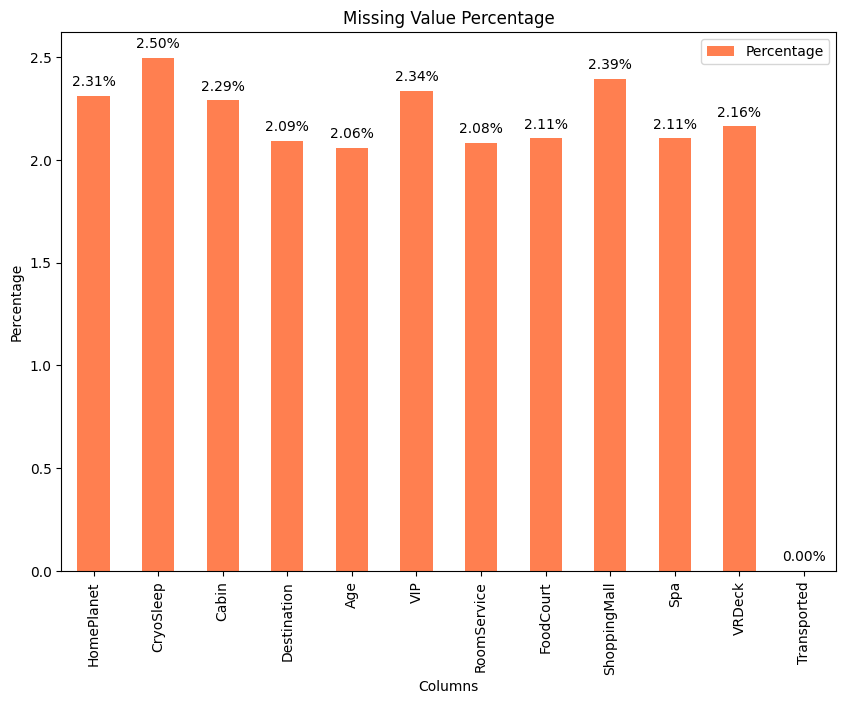

In [71]:
plt.figure(figsize=(10,7))
plt.title('Missing Value Percentage')
ax = missing_value.plot(kind='bar',color='coral')

plt.xlabel('Columns')
plt.ylabel('Percentage')

# Adding percentage values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(labels=['Percentage'])
plt.show()

# Data Analysis

In [72]:
float_cols = train_df.dtypes[train_df.dtypes=='float'].index.tolist()
object_cols = train_df.dtypes[train_df.dtypes=='object'].index.tolist()

In [73]:
float_cols

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [74]:
def plot_distribution(float_cols=None, object_cols=None, df=None,pre_df=None):
    if float_cols is not None:
        plt.figure(figsize=(14, 7))
        for i, cols in enumerate(float_cols):
            plt.subplot(2, 3, i + 1)
            sns.kdeplot(df[cols],color='darkred')
            plt.title(cols.upper())

    elif object_cols is not None:
        plt.figure(figsize=(17, 13))
        for i, cols in enumerate(object_cols):
            if cols!='Cabin' and  cols!='Name':
                plt.subplot(2, 3, i + 1)
                frequency = df[cols].value_counts()
                ax = frequency.plot(kind='bar', color='skyblue')
                for p in ax.patches:
                     ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
                        
                plt.title(cols.upper())
                
    else:
        raise ValueError("At least one of float_cols or object_cols should be provided.")

    plt.suptitle('Distribution before deleting Missing Values', fontsize=16)
    plt.tight_layout()
    plt.show()


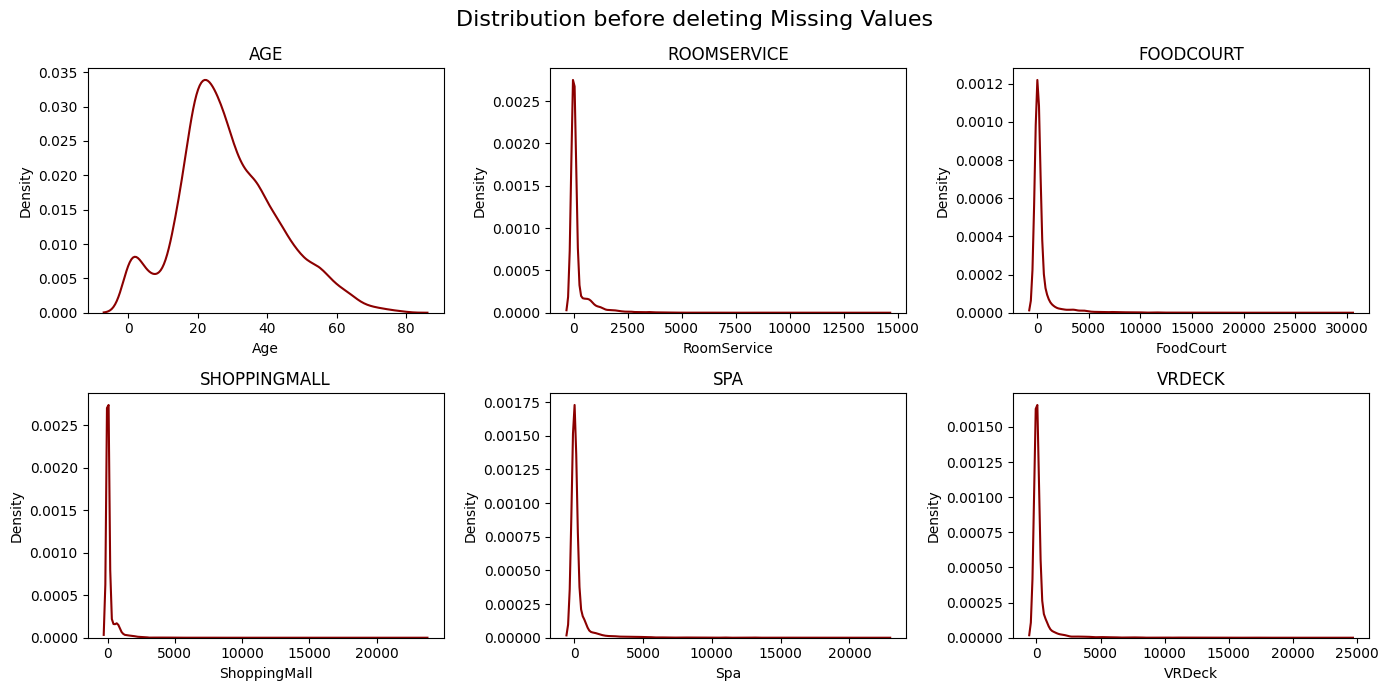

In [75]:
plot_distribution(float_cols=float_cols,df=train_df)

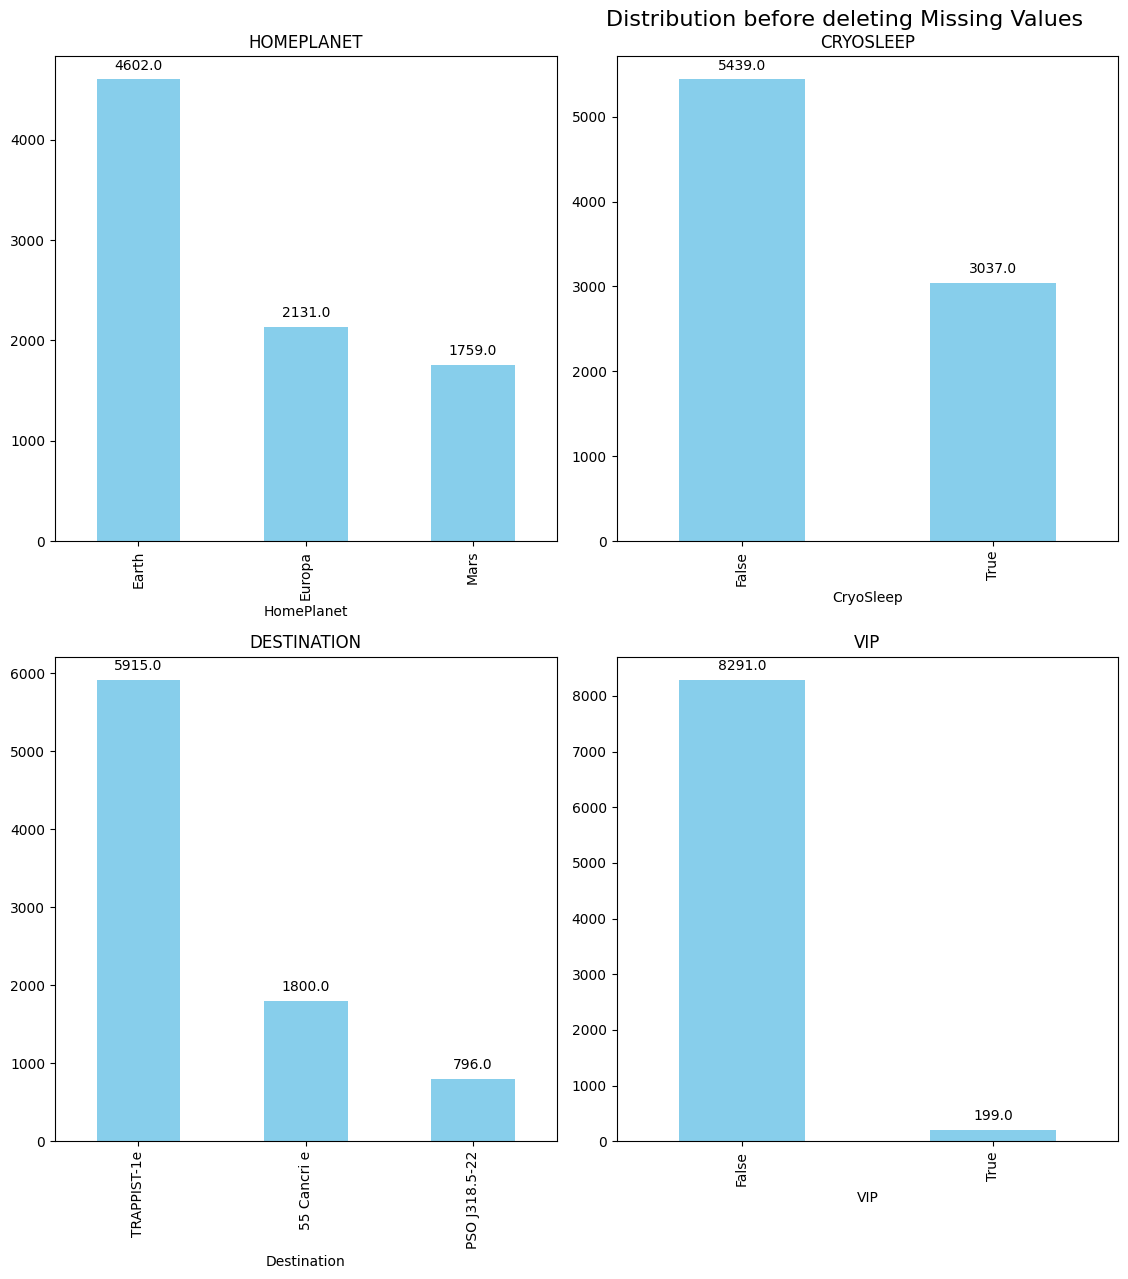

In [76]:
plot_distribution(object_cols=object_cols,df=train_df)

In [77]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [78]:
bi_cols = ['CryoSleep','VIP','Transported']

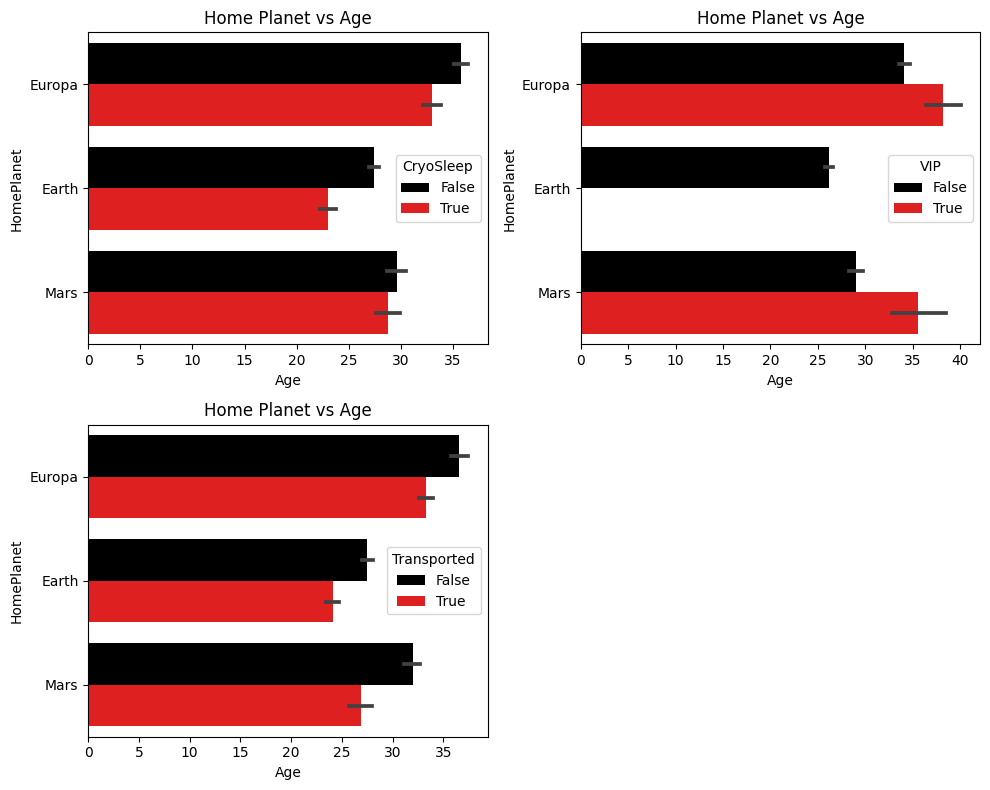

In [79]:
plt.figure(figsize=(10,8))
for i,cols in enumerate(bi_cols):
    plt.subplot(2,2,i+1)
    plt.title('Home Planet vs Age')
    sns.barplot(x = train_df['Age'],y=train_df['HomePlanet'],
            hue=train_df[cols],palette=['black','red'])
plt.tight_layout()
plt.show()

In [80]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [81]:
dist_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

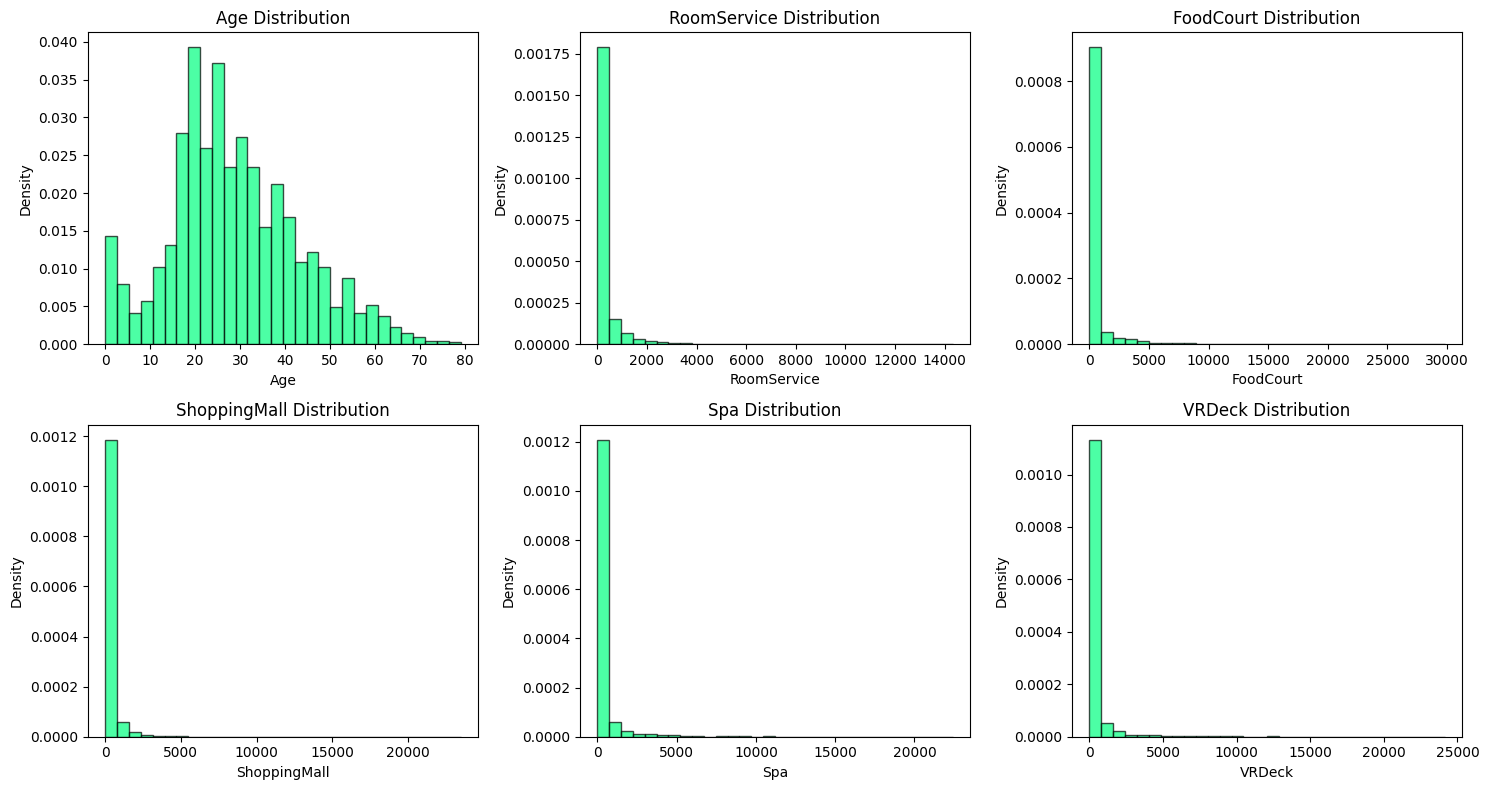

In [82]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(dist_cols, 1):
    plt.subplot(2, 3, i)
    plt.title(f"{col} Distribution")
    plt.hist(train_df[col], bins=30, density=True, alpha=0.7, 
             color='springgreen', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

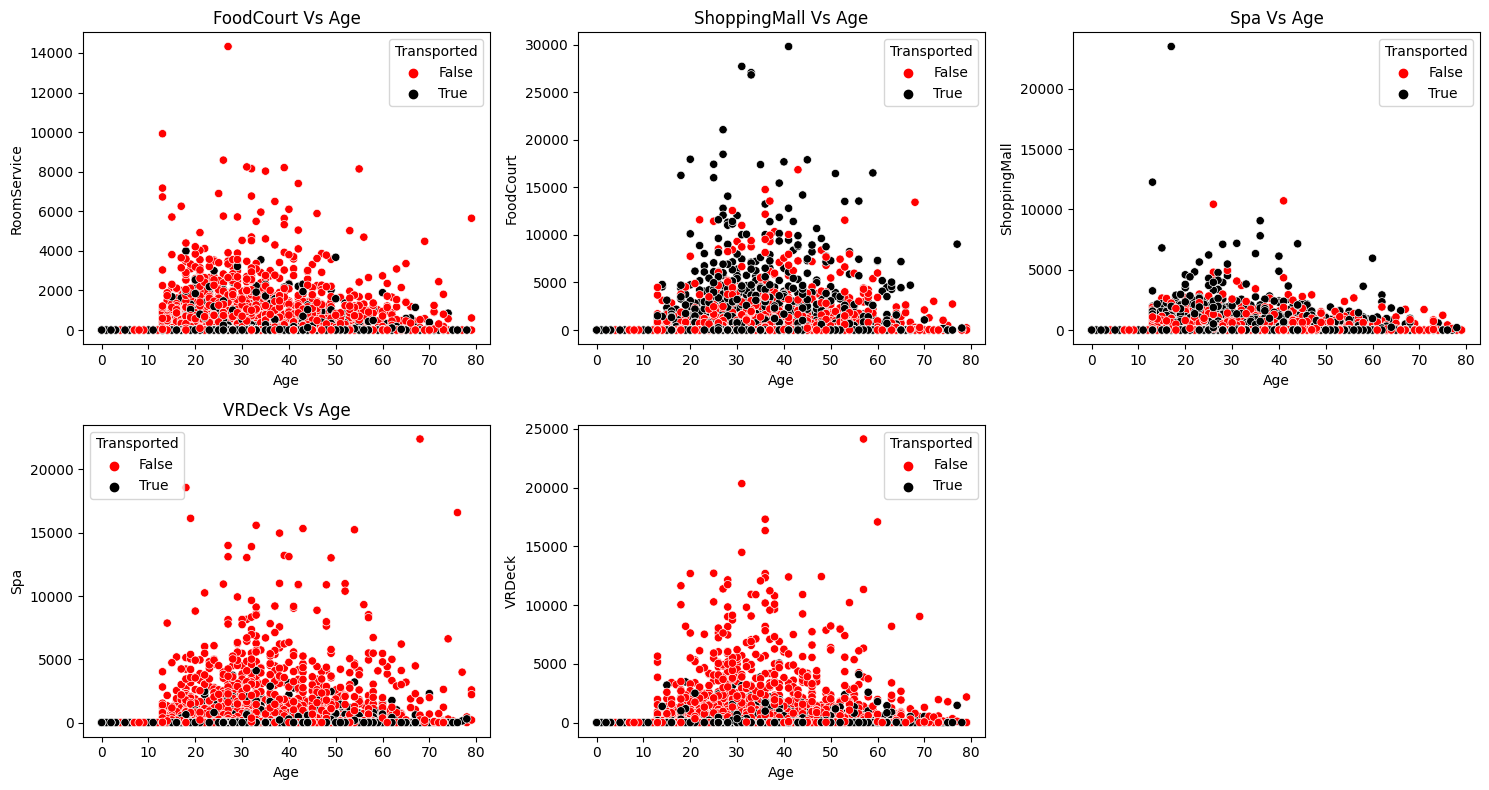

In [83]:
comp_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
plt.figure(figsize=(15, 8))
for i,cols in enumerate(comp_cols):
    plt.title(f'{cols} Vs Age')
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=train_df['Age'],
                y=train_df[cols],hue=train_df['Transported'],palette=['red','black'])
plt.tight_layout()
plt.show();

In [84]:
train_df.shape

(8693, 12)

In [85]:
train_df = train_df.dropna()

In [86]:
train_df['Cabin'].value_counts()

Cabin
C/137/S     7
E/13/S      7
G/1476/S    7
B/11/S      7
G/734/S     7
           ..
E/234/S     1
E/233/S     1
E/209/P     1
G/548/S     1
C/178/S     1
Name: count, Length: 5413, dtype: int64

# Feature Engineering and  Preprocessing

In [87]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [88]:
train_df['Destination'].value_counts()

Destination
TRAPPIST-1e      4682
55 Cancri e      1442
PSO J318.5-22     640
Name: count, dtype: int64

In [89]:
train_df['HomePlanet'].value_counts()

HomePlanet
Earth     3656
Europa    1711
Mars      1397
Name: count, dtype: int64

In [90]:
train_df['Cabin'].value_counts()

Cabin
C/137/S     7
E/13/S      7
G/1476/S    7
B/11/S      7
G/734/S     7
           ..
E/234/S     1
E/233/S     1
E/209/P     1
G/548/S     1
C/178/S     1
Name: count, Length: 5413, dtype: int64

<Axes: >

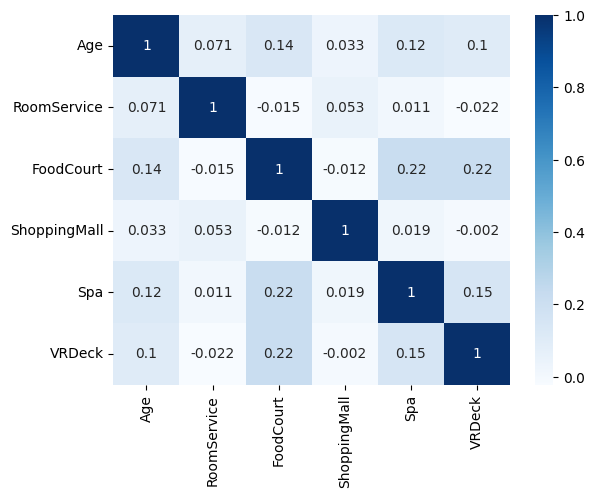

In [91]:
flt_cols = train_df.dtypes[train_df.dtypes=='float'].index.tolist()
sns.heatmap(train_df[flt_cols].corr(),annot=True,cmap='Blues')

# Identify and Remove Outliers

<Axes: >

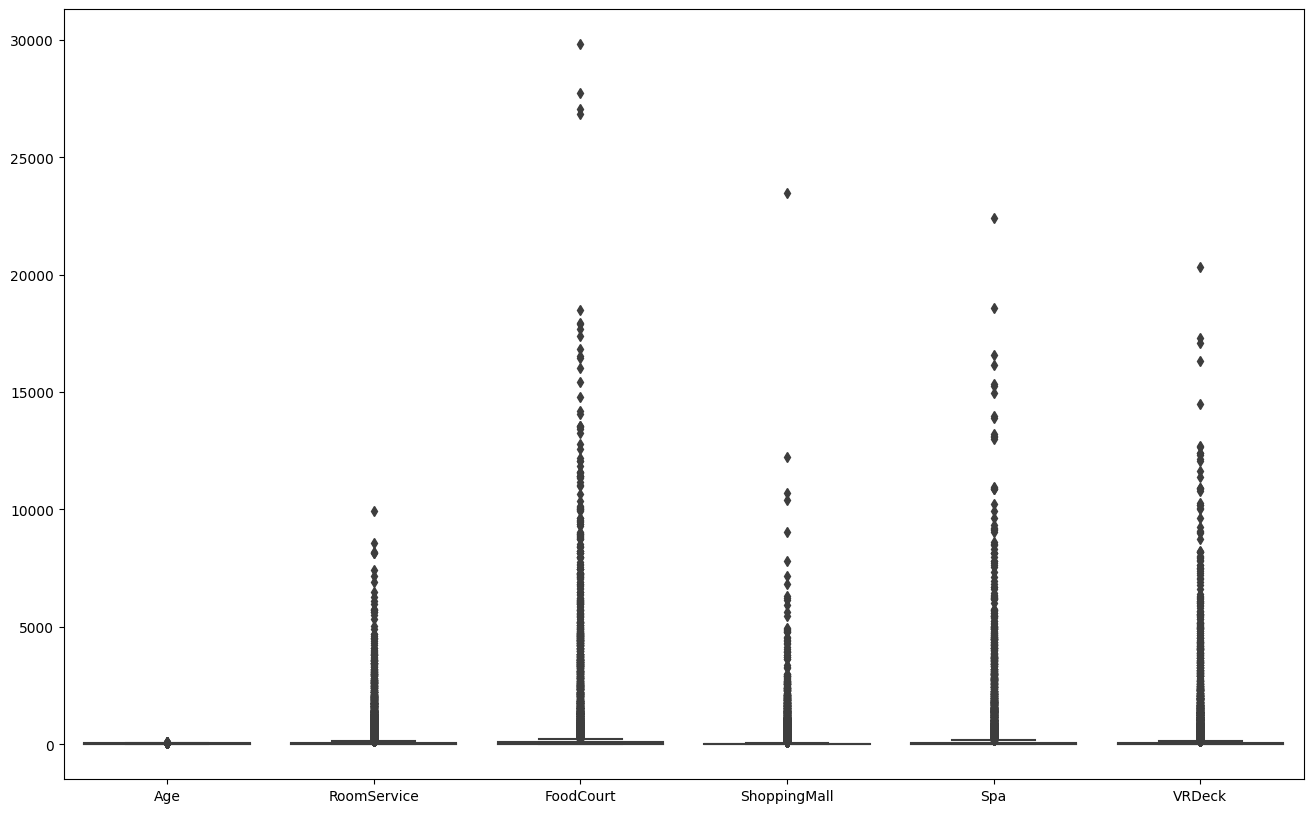

In [92]:
plt.figure(figsize=(16,10))
sns.boxplot(train_df[flt_cols])

In [93]:
X = train_df[flt_cols]

In [94]:
clf = IsolationForest(contamination=0.05)  
outlier_predictions = clf.fit_predict(X)

In [95]:
train_df['is_outlier'] = np.where(outlier_predictions == -1, True, False)

# Filter out the outliers
filtered_dataset = train_df[train_df['is_outlier'] == False].drop(columns=['is_outlier'])

In [96]:
filtered_dataset.shape

(6425, 12)

<Axes: >

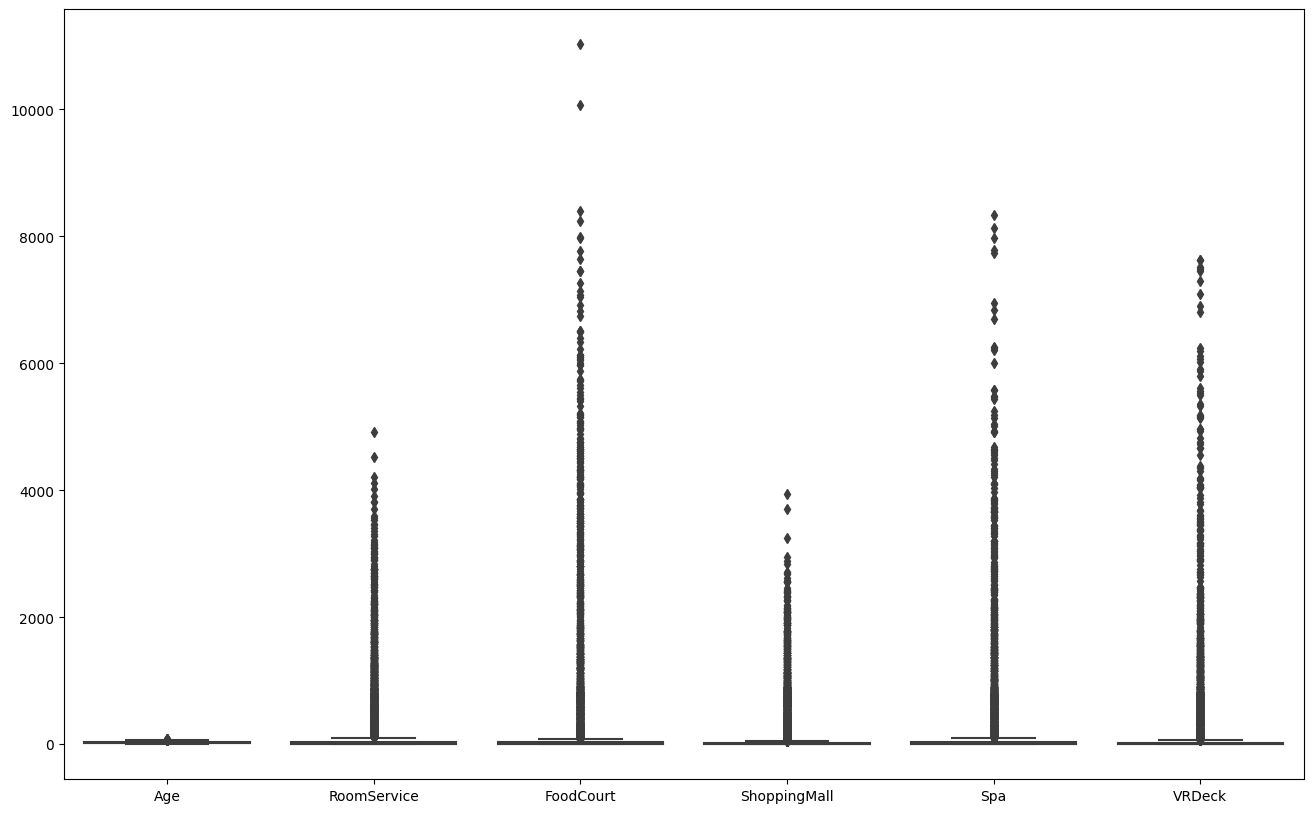

In [97]:
plt.figure(figsize=(16,10))
sns.boxplot(filtered_dataset[flt_cols])

In [98]:
train_df = filtered_dataset.copy()

In [99]:
y = train_df['Transported']
train_df.drop('Transported',axis=1,inplace=True)

In [100]:
missingValue = ColumnTransformer([
    ('numerical_fill', SimpleImputer(strategy='mean'), [4, 6, 7, 8, 9,10]),
    ('categorical_fill', SimpleImputer(strategy='most_frequent'), [0, 1, 2, 3, 5])
],remainder='passthrough')

In [101]:
missingValue.fit_transform(train_df)[0]

array([39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 'Europa', False, 'B/0/P',
       'TRAPPIST-1e', False], dtype=object)

In [102]:
preprocessing = ColumnTransformer([
    ('OrdinalEncoder',OrdinalEncoder(),[7,8,10]),
    ('OneHotEncoder',OneHotEncoder(),[6,9])
],remainder='passthrough')

In [103]:
scaler = ColumnTransformer([
    ('Scale',StandardScaler(),slice(0,10))
])

In [104]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('OrdinalEncoder', OrdinalEncoder(),
                                 [7, 8, 10]),
                                ('OneHotEncoder', OneHotEncoder(), [6, 9])])

In [105]:
pipeline = Pipeline([
    ('imputer', missingValue),
    ('encoding', preprocessing),
     ('Scaler',scaler)
])

transformed_data = pipeline.fit_transform(train_df)

In [106]:
pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_fill',
                                                  SimpleImputer(),
                                                  [4, 6, 7, 8, 9, 10]),
                                                 ('categorical_fill',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [0, 1, 2, 3, 5])])),
                ('encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OrdinalEncoder',
                                                  OrdinalEncoder(),
                                                  [7, 8, 10]),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(), [6, 9])])),
                ('Scaler',
                 ColumnTransformer(transformers=[('Scale', StandardScaler(),
                                                  slice(0, 10, None))]))])

In [107]:
transformed_data[0]

array([-0.76705979, -1.5633706 , -0.14538897, -1.14432931,  1.87232745,
       -0.51721213, -0.5041309 , -0.33145669,  0.65720196,  0.73533853])

In [108]:
le = LabelEncoder()
y = le.fit_transform(y)

In [109]:
np.unique(y,return_counts=True)

(array([0, 1]), array([3130, 3295]))

In [110]:
transformed_data.shape,y.shape

((6425, 10), (6425,))

# Data Modeling

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [112]:
x_train,x_test,y_train,y_test = train_test_split(transformed_data,y,test_size=0.2)

In [113]:
x_train.shape,x_test.shape

((5140, 10), (1285, 10))

In [114]:
def train_classification_models(x_train, y_train):
    models = {
        'RandomForest': RandomForestClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'LogisticRegression': LogisticRegression(),
        'NaiveBayes': GaussianNB(),
        'SupportVectorMachine': SVC(),
        'NeuralNetwork': MLPClassifier()
    }

    trained_models = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        trained_models[name] = model
    return trained_models

In [115]:
train_models = train_classification_models(x_train,y_train)

In [116]:
def evaluate_classification_models(x_test, y_test, trained_models):
    results = []

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(x_test)
        score = model.score(x_test, y_test)
        cm = confusion_matrix(y_test, y_pred)

        results.append({'model_name': name, 'score': score})

        # Plotting confusion matrix as a heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[i])
        axes[i].set_title(f'{name}\nAccuracy: {score:.2f}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        

    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results)
    return results_df

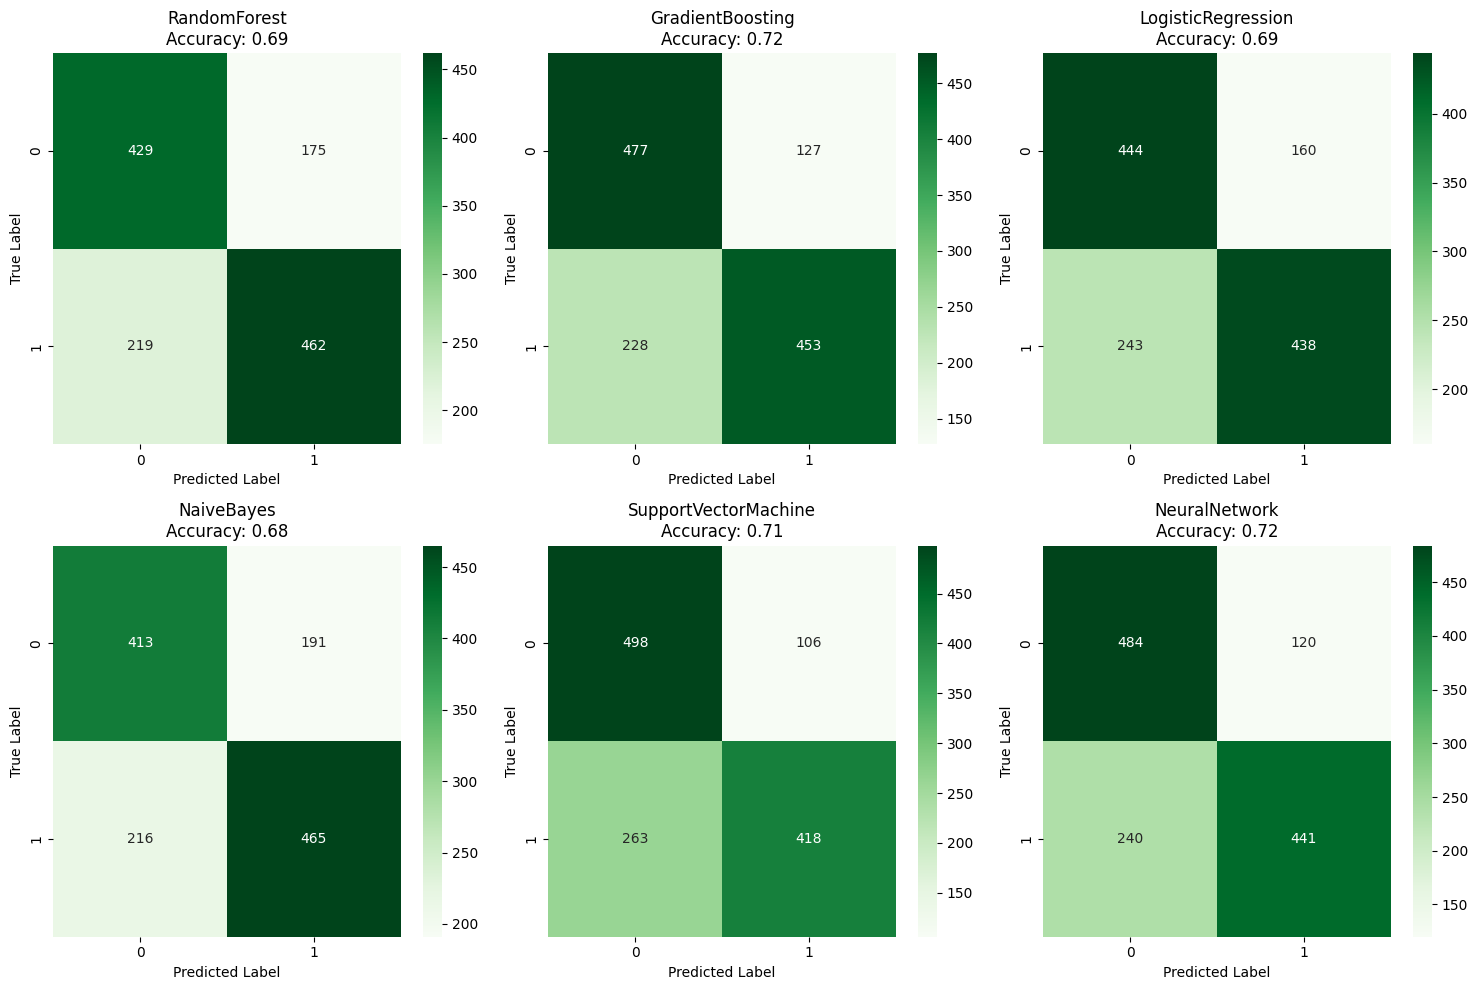

,model_name,score
0,RandomForest,0.693385
1,GradientBoosting,0.723735
2,LogisticRegression,0.686381
3,NaiveBayes,0.683268
4,SupportVectorMachine,0.712840
5,NeuralNetwork,0.719844


In [117]:
evaluate_classification_models(x_test,y_test,train_models)

# AUC (Area Under the Curve) and plot the ROC curve

In [118]:
test_pred = train_models['GradientBoosting'].predict_proba(x_test)[:,1]

AUC Score: 0.7985104200095302


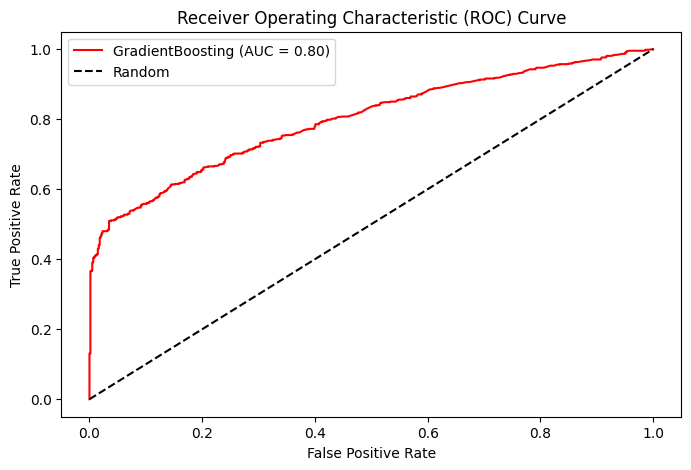

In [119]:
auc_score = roc_auc_score(y_test, test_pred)
print(f"AUC Score: {auc_score}")
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_pred)
# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'GradientBoosting (AUC = {auc_score:.2f})',color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Apply Model on Test set

In [120]:
test_df.shape

(4277, 13)

In [122]:
passengerId = test_df['PassengerId']

In [123]:
test_df.drop(['PassengerId','Name'],axis=1,inplace=True)

In [124]:
test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


In [125]:
test_set = pipeline.fit_transform(test_df)
test_set.shape

(4277, 10)

In [126]:
test_pred = train_models['GradientBoosting'].predict(test_set)

# Final Submission

In [127]:
final_list = []
for val in test_pred:
    if val==1:
        final_list.append(True)
    else:
        final_list.append(False)

In [128]:
len(final_list),test_set.shape

(4277, (4277, 10))

In [129]:
temp_dic = {'PassengerId':passengerId, 'Transported':final_list}

In [130]:
sample_submission = pd.DataFrame(temp_dic)
sample_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [131]:
sample_submission.to_csv('submission.csv', index=False)